### Step 6
### Similarity Analysis

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

In [2]:
#%pip uninstall -y nltk
#%pip install nltk --upgrade --no-cache-dir

In [3]:
import os
import shutil
import pandas as pd
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *
pd.set_option('display.max_rows', 30)

In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/safzal1/withCategories2')

In [7]:
df.count()

1731801

In [7]:
df_tweets = df.select('Tweet_Text', 'Category')

In [87]:
#df_tweets = df_tweets.withColumn("Tweet_Text", regexp_replace("Tweet_Text", r'[^\w\s]+', ""))

In [8]:
df_tweets_all = df.select('Tweet_Text')

In [9]:
frac = 10000/ df_tweets.count()

In [89]:
df_tweets_all.limit(10)

Tweet_Text
Proud to announce...
If only Lee Zeldi...
400 days since th...
Congrats to Gover...
.@DeAngelisCorey ...
This is a brillia...
What is education...
Repub dictator at...
.@DeAngelisCorey ...
Amanda Berry Smit...


### Finding Similarity for all tweets

In [10]:
text2 = df_tweets_all.sample(fraction=frac, withReplacement=False, seed= 123).rdd.map(lambda x : x['Tweet_Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [11]:
text2.count()

9871

In [12]:
def my_function(text2, jaccard_distance):

    tokens = text2\
        .map( lambda document: re.sub(r'[^a-zA-Z0-9 ]', '', document))\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x.replace("#","") for x in word if True])\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .map( lambda word: [x for x in word if len(x) > 1] )\
        .zipWithIndex()   
    
    row = Row('Tweet_Text')
    text2=text2.map(row).zipWithIndex().toDF(['text','id'])
    
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

    vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
    df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()
    
    df_hashed_text = text2.join(df_hashed, "id", how = 'left').cache()
    
    
    df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))
    dup = df_dups_text.dropDuplicates(['text_A']).toPandas()
    dup = dup.shape[0]
    
    records = df_hashed_text.count()
    uniques = records - dup

    return uniques, dup

In [13]:
df_score = pd.DataFrame(columns = ['Entity','Jaccard_Threshold','Uniques','Near_Duplicates'])

In [14]:
# for All tweets
jacards = [0.3,0.4,0.5,0.6,0.7]
for i in range(0,5):
    a,b = my_function(text2, jacards[i] )
    new_row = {'Entity': 'All', 'Jaccard_Threshold': jacards[i], 'Uniques': a, 'Near_Duplicates' :b}
    print(a,b)
    df_score = df_score.append(new_row, ignore_index=True)


8448 1423


8328 1543


8252 1619


8138 1733


7930 1941


In [15]:
df_score

,Entity,Jaccard_Threshold,Uniques,Near_Duplicates
0,All,0.3,8448,1423
1,All,0.4,8328,1543
2,All,0.5,8252,1619
3,All,0.6,8138,1733
4,All,0.7,7930,1941


In [16]:
df_score.to_csv("gs://msca-bdp-students-bucket/shared_data/safzal1/similarities/all_again_afterregex.csv", mode = 'w')

### Finding Similarity for all Non Profit

In [17]:
df_tweets_ngo = df_tweets.filter(col('Category') == 'Non Profit Org')

In [18]:
df_tweets_ngo.count()

89129

In [19]:
frac = 10000/ df_tweets_ngo.count()

In [20]:
text2 = df_tweets_ngo.sample(fraction=frac, withReplacement=False, seed = 123).rdd.map(lambda x : x['Tweet_Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [21]:
text2.count()

10084

In [22]:
# for All tweets
jacards = [0.2,0.3,0.4,0.5,0.6,0.7]
for i in range(0,6):
    a,b = my_function(text2, jacards[i] )
    new_row = {'Entity': 'NGO', 'Jaccard_Threshold': jacards[i], 'Uniques': a, 'Near_Duplicates' :b}
    df_score = df_score.append(new_row, ignore_index=True)


In [23]:
df_score

,Entity,Jaccard_Threshold,Uniques,Near_Duplicates
0,All,0.3,8448,1423
1,All,0.4,8328,1543
2,All,0.5,8252,1619
3,All,0.6,8138,1733
4,All,0.7,7930,1941
5,NGO,0.2,8806,1278
6,NGO,0.3,8780,1304
7,NGO,0.4,8762,1322
8,NGO,0.5,8742,1342
9,NGO,0.6,8705,1379


In [24]:
df_score.to_csv("gs://msca-bdp-students-bucket/shared_data/safzal1/similarities/all_again_afterregex.csv", mode = 'w')

### Finding Similarity for all Government Entities

In [25]:
df_tweets_govt = df_tweets.filter(col('Category') == 'Government Entities')

In [26]:
df_tweets_govt.count()

343520

In [27]:
frac = 10000/ df_tweets_govt.count()

In [28]:
text2 = df_tweets_govt.sample(fraction=frac, withReplacement=False, seed = 123).rdd.map(lambda x : x['Tweet_Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [29]:
text2.count()

9894

In [ ]:
jacards = [0.3,0.4,0.5,0.6,0.7]
for i in range(0,5):
    a,b = my_function(text2, jacards[i] )
    new_row = {'Entity': 'Government', 'Jaccard_Threshold': jacards[i], 'Uniques': a, 'Near_Duplicates' :b}
    df_score = df_score.append(new_row, ignore_index=True)


In [ ]:
df_score

,Entity,Jaccard_Threshold,Uniques,Near_Duplicates
0,All,0.3,8448,1423
1,All,0.4,8328,1543
2,All,0.5,8252,1619
3,All,0.6,8138,1733
4,All,0.7,7930,1941
5,NGO,0.2,8806,1278
6,NGO,0.3,8780,1304
7,NGO,0.4,8762,1322
8,NGO,0.5,8742,1342
9,NGO,0.6,8705,1379


In [39]:
df_score.to_csv("gs://msca-bdp-students-bucket/shared_data/safzal1/similarities/all_again_afterregex.csv", mode = 'w')

### Finding Similarity for all University Entities

In [40]:
df_tweets_uni = df_tweets.filter(col('Category') == 'University')

In [41]:
df_tweets_uni.count()

273202

In [42]:
frac = 10000/ df_tweets_uni.count()

In [43]:
text2 = df_tweets_uni.sample(fraction=frac, withReplacement=False, seed = 123).rdd.map(lambda x : x['Tweet_Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [44]:
text2.count()

10024

In [ ]:
jacards = [0.3,0.4,0.5,0.6,0.7]
for i in range(0,5):
    a,b = my_function(text2, jacards[i] )
    new_row = {'Entity': 'University', 'Jaccard_Threshold': jacards[i], 'Uniques': a, 'Near_Duplicates' :b}
    df_score = df_score.append(new_row, ignore_index=True)


In [45]:
df_score

,Entity,Jaccard_Threshold,Uniques,Near_Duplicates
0,All,0.3,8448,1423
1,All,0.4,8328,1543
2,All,0.5,8252,1619
3,All,0.6,8138,1733
4,All,0.7,7930,1941
5,NGO,0.2,8806,1278
6,NGO,0.3,8780,1304
7,NGO,0.4,8762,1322
8,NGO,0.5,8742,1342
9,NGO,0.6,8705,1379


In [46]:
df_score.to_csv("gs://msca-bdp-students-bucket/shared_data/safzal1/similarities/all_again_afterregex.csv", mode = 'w')

### Finding Similarity for all School

In [47]:
df_tweets_sch = df_tweets.filter(col('Category') == 'School')

In [48]:
df_tweets_sch.count()

35523

In [49]:
frac = 10000/ df_tweets_sch.count()

In [50]:
text2 = df_tweets_sch.sample(fraction=frac, withReplacement=False, seed = 123).rdd.map(lambda x : x['Tweet_Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [51]:
text2.count()

9942

In [52]:
jacards = [0.3,0.4,0.5,0.6,0.7]
for i in range(0,5):
    a,b = my_function(text2, jacards[i] )
    new_row = {'Entity': 'School', 'Jaccard_Threshold': jacards[i], 'Uniques': a, 'Near_Duplicates' :b}
    df_score = df_score.append(new_row, ignore_index=True)


In [53]:
df_score

,Entity,Jaccard_Threshold,Uniques,Near_Duplicates
0,All,0.3,8448,1423
1,All,0.4,8328,1543
2,All,0.5,8252,1619
3,All,0.6,8138,1733
4,All,0.7,7930,1941
5,NGO,0.2,8806,1278
6,NGO,0.3,8780,1304
7,NGO,0.4,8762,1322
8,NGO,0.5,8742,1342
9,NGO,0.6,8705,1379


In [54]:
df_score.to_csv("gs://msca-bdp-students-bucket/shared_data/safzal1/similarities/all_again_afterregex.csv", mode = 'w')

### Finding Similarity for all News Entities

In [55]:
df_tweets_news = df_tweets.filter(col('Category') == 'News Outlets')

In [56]:
df_tweets_news.count()

183925

In [57]:
frac = 10000/ df_tweets_news.count()

In [58]:
text2 = df_tweets_news.sample(fraction=frac, withReplacement=False, seed = 123).rdd.map(lambda x : x['Tweet_Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [59]:
text2.count()

10050

In [ ]:
jacards = [0.3,0.4,0.5,0.6,0.7]
for i in range(0,5):
    a,b = my_function(text2, jacards[i] )
    new_row = {'Entity': 'News Outlets', 'Jaccard_Threshold': jacards[i], 'Uniques': a, 'Near_Duplicates' :b}
    df_score = df_score.append(new_row, ignore_index=True)


In [ ]:
df_score

,Entity,Jaccard_Threshold,Uniques,Near_Duplicates
0,All,0.3,8448,1423
1,All,0.4,8328,1543
2,All,0.5,8252,1619
3,All,0.6,8138,1733
4,All,0.7,7930,1941
...,...,...,...,...
27,News Outlets,0.3,8851,1199
28,News Outlets,0.4,8826,1224
29,News Outlets,0.5,8812,1238
30,News Outlets,0.6,8784,1266


In [ ]:
#df_score.to_csv("gs://msca-bdp-students-bucket/shared_data/safzal1/similarities/all.csv", mode = 'w')

In [63]:
df_score.to_csv("gs://msca-bdp-students-bucket/shared_data/safzal1/similarities/all_again_afterregex.csv", mode = 'w')

### Finding Similarity for all SM Influencer 

In [64]:
df_tweets_SM = df_tweets.filter(col('Category') == 'Social Media Influencer')

In [65]:
df_tweets_SM.count()

68538

In [66]:
frac = 10000/ df_tweets_SM.count()

In [67]:
text2 = df_tweets_SM.sample(fraction=frac, withReplacement=False, seed = 123).rdd.map(lambda x : x['Tweet_Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [68]:
text2.count()

10124

In [ ]:
# for All tweets
jacards = [0.3,0.4,0.5,0.6,0.7]
for i in range(0,5):
    a,b = my_function(text2, jacards[i] )
    new_row = {'Entity': 'Social Media Influencer', 'Jaccard_Threshold': jacards[i], 'Uniques': a, 'Near_Duplicates' :b}
    df_score = df_score.append(new_row, ignore_index=True)


In [84]:
pd.set_option('display.max_rows', 50)

In [85]:
df_score

,Entity,Jaccard_Threshold,Uniques,Near_Duplicates
0,All,0.3,8448,1423
1,All,0.4,8328,1543
2,All,0.5,8252,1619
3,All,0.6,8138,1733
4,All,0.7,7930,1941
6,NGO,0.3,8780,1304
7,NGO,0.4,8762,1322
8,NGO,0.5,8742,1342
9,NGO,0.6,8705,1379
10,NGO,0.7,8620,1464


In [86]:
df_score.to_csv("gs://msca-bdp-students-bucket/shared_data/safzal1/similarities/all_again_afterregex.csv", mode = 'w', index = False)

### Finding Similarity for all others

In [74]:
df_tweets_oth = df_tweets.filter(col('Category') == 'others')

In [75]:
df_tweets_oth.count()

737964

In [76]:
frac = 10000/ df_tweets_oth.count()

In [77]:
text2 = df_tweets_oth.sample(fraction=frac, withReplacement=False, seed = 123).rdd.map(lambda x : x['Tweet_Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [78]:
text2.count()

9871

In [79]:
# for others category tweets
jacards = [0.3,0.4,0.5,0.6,0.7]
for i in range(0,5):
    a,b = my_function(text2, jacards[i] )
    new_row = {'Entity': 'Others', 'Jaccard_Threshold': jacards[i], 'Uniques': a, 'Near_Duplicates' :b}
    df_score = df_score.append(new_row, ignore_index=True)


In [89]:
df_pd = df_score

In [90]:
df_pd.Entity[df_pd.Entity == 'Social Media Influencer'] = 'SM Influencers'

In [91]:
df_pd['Frac_of_Dups'] = df_pd.Near_Duplicates / (df_pd.Uniques + df_pd.Near_Duplicates)

In [92]:
df_pd['Frac_of_Uniq'] = df_pd.Uniques / (df_pd.Uniques + df_pd.Near_Duplicates)

In [101]:
df_pd.Uniques = df_pd.Uniques.astype('int')
df_pd.Near_Duplicates = df_pd.Near_Duplicates.astype('int')
df_pd.Frac_of_Dups = df_pd.Frac_of_Dups.astype('float')
df_pd.Frac_of_Uniq = df_pd.Frac_of_Uniq.astype('float')

In [117]:
df_pd['Per_of_Dups'] = df_pd['Frac_of_Dups'] * 100

In [118]:
df_pivot = df_pd.pivot_table(index='Entity', columns='Jaccard_Threshold', values='Per_of_Dups')

In [119]:
df_pivot = df_pivot.round(3)

<Figure size 1920x1440 with 0 Axes>

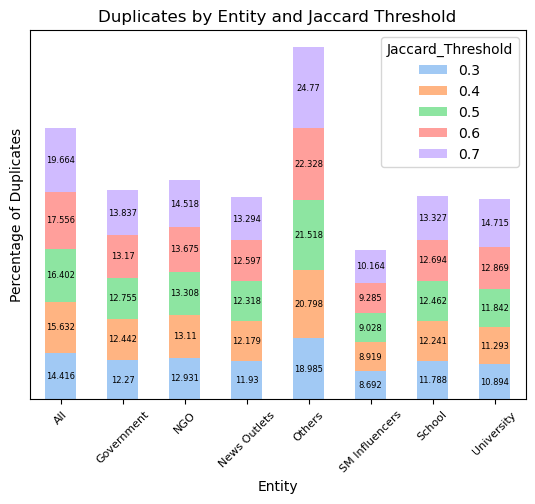

In [126]:
plt.figure(dpi = 300)
colors = sns.color_palette('pastel')[0:5]
ax = df_pivot.plot(kind='bar', stacked=True, color = colors)
plt.xlabel('Entity')
plt.ylabel('Percentage of Duplicates')
plt.title('Duplicates by Entity and Jaccard Threshold')
plt.xticks(fontsize=8, rotation = 45)
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=6)
plt.yticks([])
plt.show()